In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
import pickle
import pyarrow.parquet as pq
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster, single, complete, average
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples,silhouette_score

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [3]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 2 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [ ]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [4]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= PCA(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [21]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(18055, 3)


In [ ]:
#dfDados = dfDados.sample(frac=0.5, random_state=123)
#print(dfDados.shape)

(14061, 3)


In [85]:
dfx = pd.DataFrame(df.reset_index())
dfx['index'].tolist()[0:10]

['politica',
 'colunas',
 'economia',
 'esporte',
 'bbc',
 'mundo',
 'folhinha',
 'cotidiano',
 'empreendedorsocial',
 'comida']

75


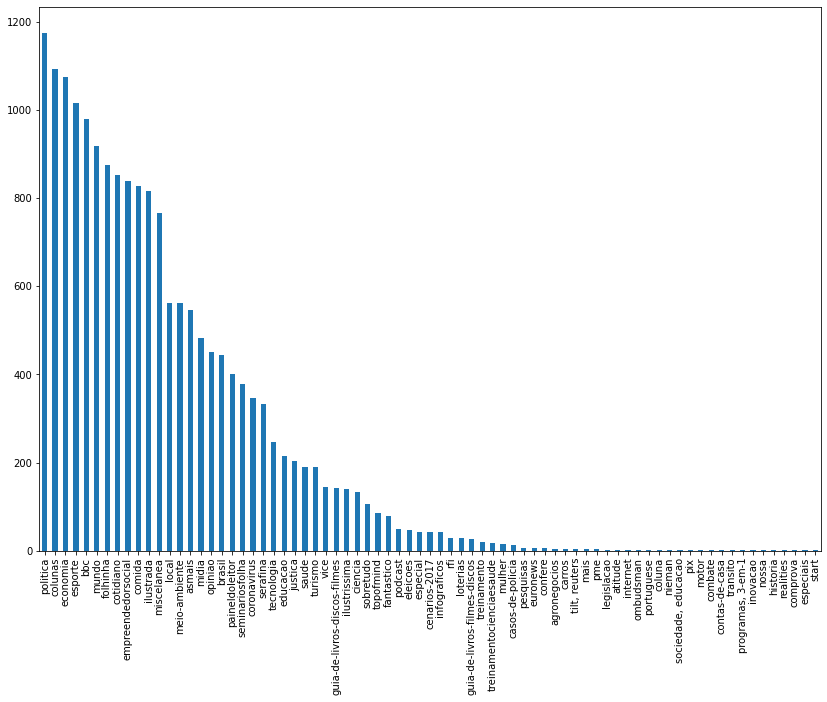

In [70]:
df = dfDados['category'].value_counts()
print(dfDados['category'].unique().size)
df.plot.bar(figsize=(14,10))


In [22]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 1.7 s, sys: 549 ms, total: 2.25 s
Wall time: 4min 42s


In [9]:
print(dfPreProc.shape)
dfPreProc.head()

(18055, 3)


,text,category,category_nro
0,tent recuper imag pt abal oper lav jat expresid luiz ináci lul silv program final junh cronogram encontr reuni país mov soc centr sindic obje péripl recuper apoi bas soc sigl reaproximál part mobilizál defês ano legend frent govern feder intenç petist prior visit est ond part apoi consolid obtev vantag urn segund turn disput presid ano pass min geral rio jan bah pernambuc ce rio grand nort pretend inclu rot grand cidad tradic milit petist campin sp port alegr rs seman pass lul acr avali cúpul nacion sigl reaproxim esquerd mov necess super cris polít garant pt cheg competi disput eleitor fest prim mai organiz capit paul cut centr únic trabalh petist hav sinal far viag país segund ali assessor expresid demonstr preocup manifestaç hostil contr presid dilm rousseff pt cresc reje part set sociedad crít convers recent reclam atu govern feder di atual cris polít segund vez adot agend posi paláci planalt concentr apen ajust fiscal tem consider impopul nest terç lul cheg critic man ajust fiscal send feit diz err mud regr segurodesempreg med provisór além diss acord relat petist expresid lembr cinc mes presid lanç aind program inici poss torn marc segund mandat sob influ anteces paláci planalt dilm inici desd final mê pass esforç reaproxim centr sindic mov soc presid reunius represent conselh nacion saúd confeder nacion trabalh agricult centr sindic secret geral presid repúbl articul aind agend encontr petist outr mov soc entidad defês direit human igualdad rac gêner combat misér,politica,0
1,procuradorger repúbl rodrig janot ped abert inquérit stf supr tribun feder apur sen josé serr psdbsp receb cerc r milh mei caix doi jb campanh presid dela jb empres joesley batist don frigoríf diss fez doaç contabil campanh afirm pass r milh apen r milh declar justiç eleitor acord dela serr procur sed jb paul ped financ disput eleitor segund r milh pag mei emiss not fiscal lrc event promoç simul aquis camarot fórmul outr r mil pag mei empr appm anális pesquis afirm joesley tucan fic segund lug disput presid perd expresid dilm rousseff ped feit ministr edson fachin homolog del execu jb janot ped cas redistribu outr magistr vez acusaç feit dela jb relaç esquem corrupç petrobr janot ped stf autoriz tom depo respons empr event pesquis própri josé serr ped aind empr lrc event promoç appm anális pesquis prest esclarec necess refer serviç supost prest der orig not fiscal report consegu contat empr mei assess imprens sen afirm tod campanh eleitor conduz dentr lei finanç sob respons part nunc oferec nenhum contrapart doaç eleitor aliás confirm senh joesley batist,politica,0
2,morr nest doming paul ano ativ soc mar helen gregor mulh exministr justiç josé gregor trajetór marc milit contr ditad favor anist direit human mar helen deix trê filh mar stell mar filomen mar cecíl juventud mar helen integr comit execu organiz diret realiz eleiç presid após golp atu bast campanh franc montor govern paul fern henriqu card prefeit capit paul assessor espec direit human exprefeit luiz erundin psb amig ruth card chefi gabinet exprimeiradam ong comunidad solidár presid fundacentr paul desd vinh lut contr séri problem saúd lúpu cânc recent est agrav decorr pneumon marc espírit cívic acentu forç pessoal grand super tod dificuldad últ ano diz filh mar filomen exministr josé gregor cas mar helen ano lembr mulh trabalh fortalec mov femin nasc dispos ativ soc fez cas espéci sal reuni permanent discuss sobr diret velóri mar helen acontec nest doming rua carl pinh part h enterr nest segundaf h cemitéri consol,politica,0
3,sen aéci nev psdbmg afirm nest segundaf psdb far inserç rádi televis convoc pesso particip manifestaç contr govern marc agost apes afirm part dev ser protagon protest tucan diz legend pod omit nest moment segund sen propagand part apel indign cidad relaç açe govern indign arrepend princip cans dev sim moviment ir rua diss inserç começ ser veicul nest seman prim fas psdb mostr princip lideranç expresid fern henriqu card govern paul ge

In [ ]:
#dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv',index=False)
#dfPreProc = pd.read_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv')
#dfPreProc['text'] = dfPreProc['text'].astype('unicode')

In [23]:
V = processaVetorizacao(dfPreProc,min_fr=0.05, max_fr=0.7, ngrams=(1,2))
X_tfidf = retornaMatriztfIdf(V)

In [11]:
%%time
#https://www.kaggle.com/tchainzzz/agglomerative-document-clustering-on-cord-19

dist = 1 - cosine_similarity(X_tfidf)
dist = dist - dist.min()
#linkage_matrix = average(dist) #ward(dist)

CPU times: user 26.2 s, sys: 2.41 s, total: 28.6 s
Wall time: 28.4 s


In [12]:
with open('./amostra_news_integrada/amostra_4/dist_cosine.npy', 'wb') as f:
    np.save(f, dist)
f.close()

In [8]:
with open('./amostra_news_integrada/amostra_4/dist_cosine.npy', 'rb') as f:
  dist = np.load(f)
f.close()
print(dist.shape)

(18055, 18055)


In [24]:
#normalizando e aplicando PCA
#X_norm  = padronizaValores(X_tfidf)
X_pca = normalizaEreduzDimensionalidadecomPCA(X_tfidf.toarray(),2)[1]
#X_pca = normalizaEreduzDimensionalidadecomPCA(dist,2)[1]
#print(dist.shape, X_pca.shape)


In [10]:
with open('./amostra_news_integrada/amostra_4/x_pca.npy', 'wb') as f:
    np.save(f, X_pca)
f.close()

In [12]:
!ls ./amostra_news_integrada/amostra_4/ -lh

total 2.5G
-rw------- 1 root root  53M Aug 28 14:27 amostra.csv
-rw------- 1 root root 2.5G Aug 28 14:42 dist_cosine.npy
-rw------- 1 root root 283K Aug 28 17:00 x_pca.npy


In [34]:
with open('./amostra_news_integrada/amostra_4/x_pca.npy', 'rb') as f:
    X_pca = np.load(f)
f.close()
print(X_pca.shape)

(18055, 2)


In [ ]:
## mostrar o percentual de representatividade de cada dimensão do PCA
data_pca=PCA(svd_solver='full')
data_transformed = data_pca.fit(dist)
plt.rcParams['figure.figsize'] = [12, 6]
f, (ax1, ax2)  = plt.subplots(1,2)

ax1.plot(data_pca.explained_variance_ratio_, '*') 
ax2.plot(data_pca.explained_variance_ratio_[:20], '*') 




(-15.0, 15.0)

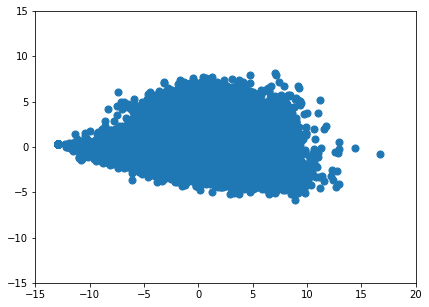

In [132]:
plt.figure(figsize=(15,5))
# mostra o primeiro gráfico
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:,0], X_pca[:,1],  cmap='viridis', s=50)
plt.xlim(-15,20)
plt.ylim(-15,15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


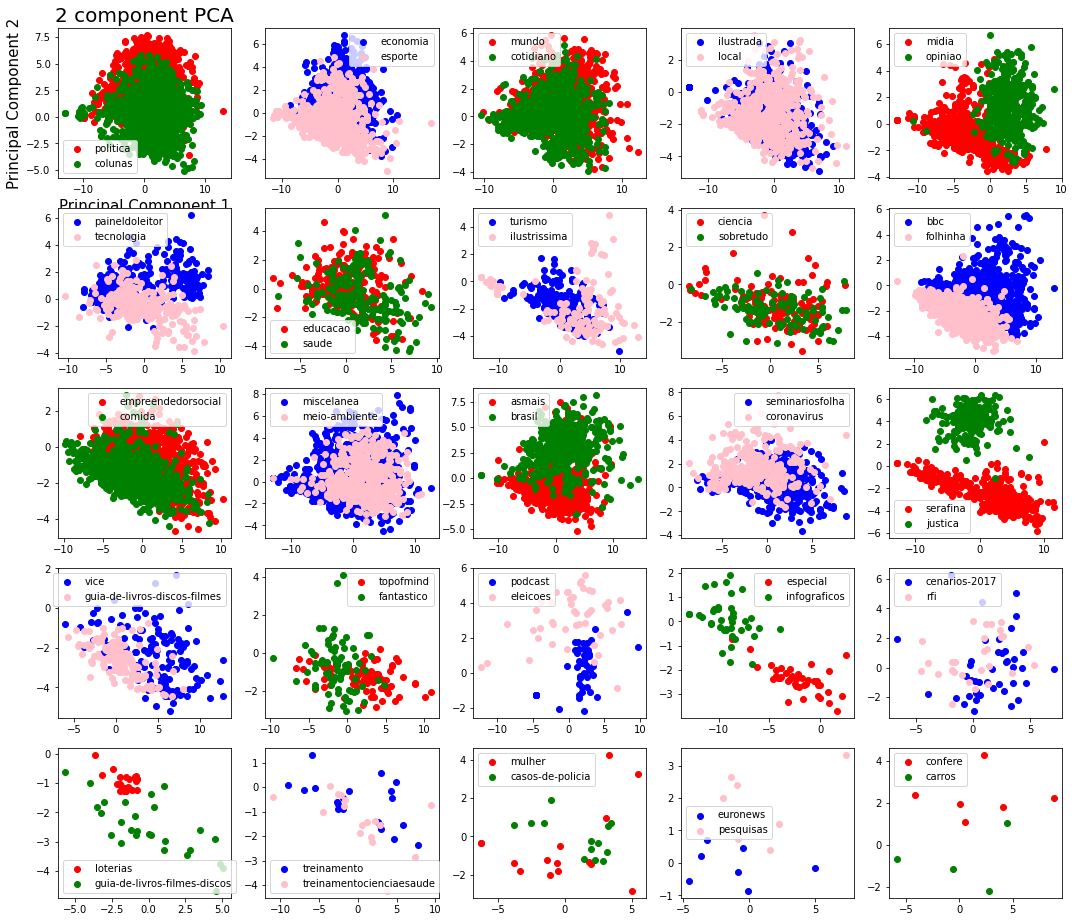

In [156]:
df_pca = pd.DataFrame(X_pca, columns=['c1','c2'])
df_pca['category'] = dfDados['category']

fig = plt.figure(figsize = (18,16))
ax = fig.add_subplot(5,5,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['politica', 'colunas', 'economia', 'esporte', 'bbc', 
#           'mundo', 'folhinha', 'cotidiano', 'empreendedorsocial', 'comida']
targets = df_pca['category'].unique().tolist()[0:50]

#ax = fig.add_subplot(5,5,1) 
colors = ['r', 'g']
i=1
legenda=[]
for idx, target in enumerate(targets):
    legenda.append(target)
    indicesToKeep = df_pca['category'] == target
    ax = fig.add_subplot(5,5,i)
    ax.scatter(df_pca.loc[indicesToKeep, 'c1']
               , df_pca.loc[indicesToKeep, 'c2']
               , c = colors[idx%2]
               )
    if idx % 2!=0 and (idx>=1):
      i+=1
      ax.legend(legenda)
      legenda=[]
      if i%2==0:
        colors = ['blue', 'pink']
      else:
        colors = ['red', 'green']
    
    
#ax.grid()

* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
* https://medium.com/@gilneyjnr/qualidade-de-agrupamentos-ci%C3%AAncia-de-dados-4b1176bef5e5


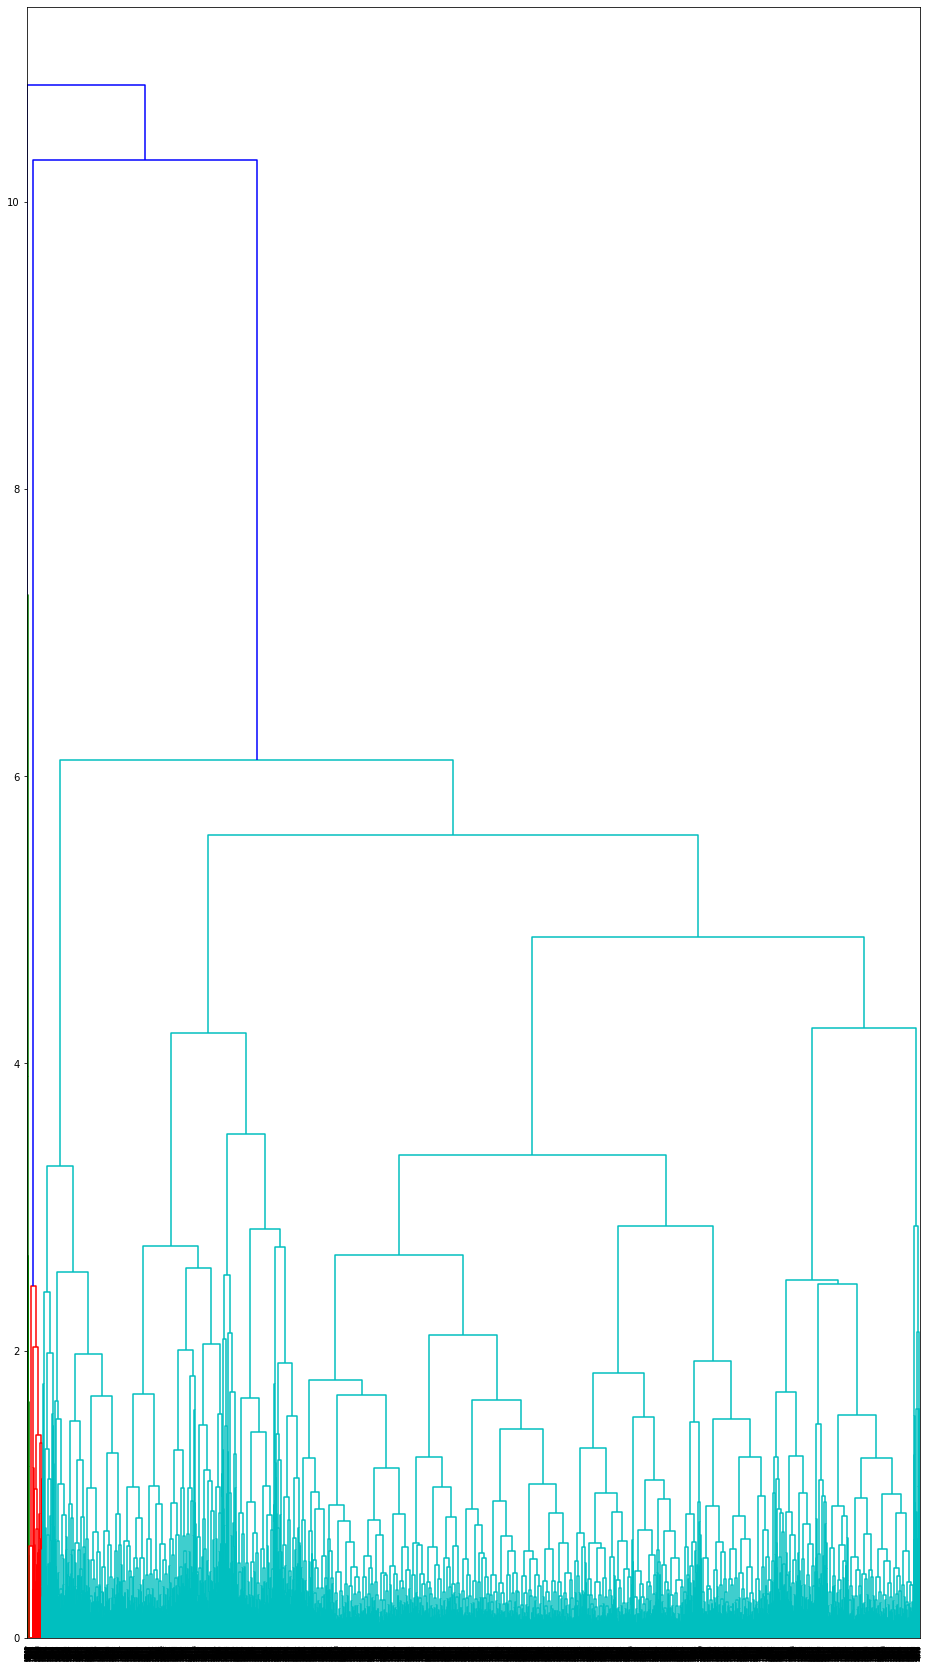

CPU times: user 6min, sys: 29.9 s, total: 6min 30s
Wall time: 6min 22s


In [ ]:
%%time
plt.figure(figsize=(16, 30))
dendrogram = sch.dendrogram(sch.linkage(X_pca, method='average'))
plt.show()

Similaridade Coseno

In [ ]:
#X_cosine = X_tfidf.toarray()
#print(np.where(~X_cosine.any(axis=1))[0])
#z = np.where(~X_cosine.any(axis=1))[0]
#for i in z:
#  X_cosine[i] = np.ones(X_cosine[i].shape)*1/100
#print(np.where(~X_cosine.any(axis=1))[0])

[   38   122   303   712   734  1017  1037  1072  1243  1330  1519  1864
  2098  2390  2676  3143  3702  3817  3843  4121  4161  4240  4282  4332
  4345  4390  4659  4952  5050  5146  5408  5555  5788  5840  5908  6080
  6154  6518  6529  6647  6901  6958  7012  7067  7121  7424  7470  7532
  7662  7701  7853  7897  8037  8242  8501  8573  8873  8884  9165  9240
  9855 10096 10323 10728 10821 11072 11248 11389 11403 11604 11762 11833
 11882 12077 12339 12752 12850 12962 13274 13400 13513 13842]
[]


Clusterizando

In [209]:
#model= AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='average')
#dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)
k=8
model= AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average') 
y_pred = model.fit_predict(X_pca)

<BarContainer object of 8 artists>

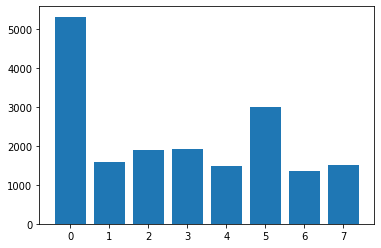

In [210]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


In [14]:
download_pt_stopWords()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


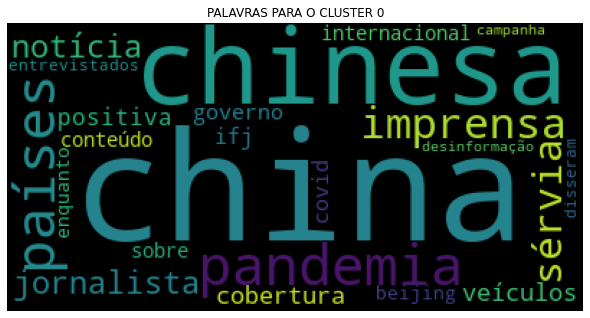

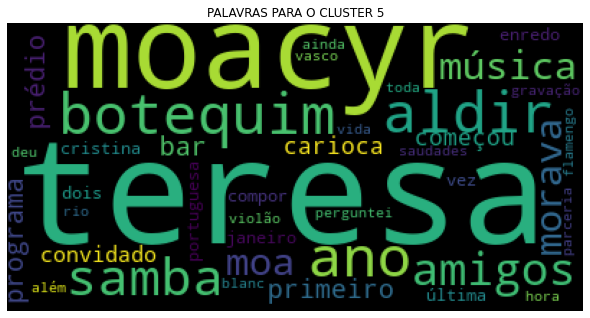

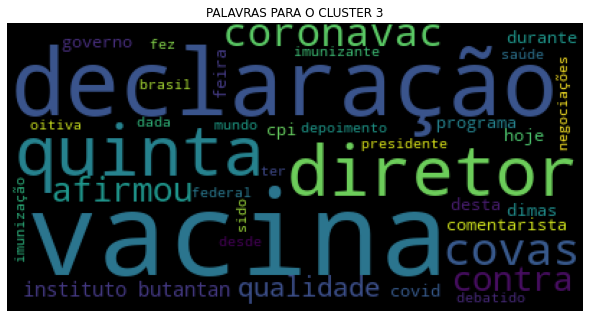

In [ ]:
#dfconta = dfDados['y_pred'].value_counts().reset_index()
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['y_pred'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),500,str(y),sw)

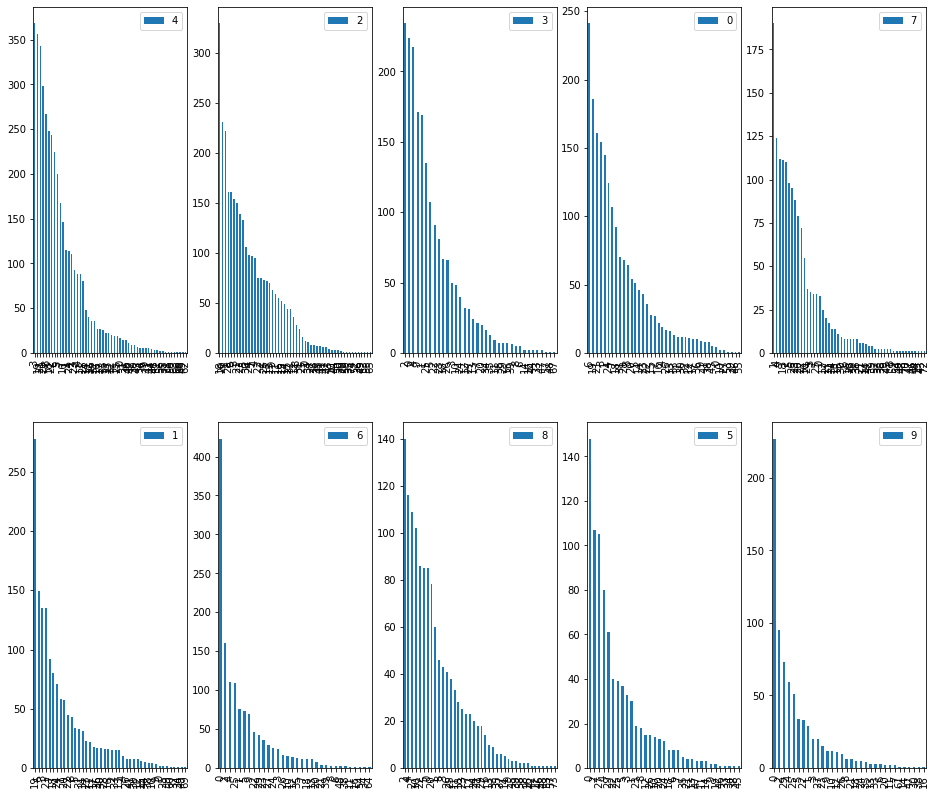

In [205]:
fig = plt.figure(figsize = (16,14))
for i, y in enumerate(dfconta['y_pred'].tolist()):
  dftmp = dfDados.loc[:,['category_nro']][dfDados['y_pred']==y]
  ax = fig.add_subplot(2,5,i+1)
  df = dftmp['category_nro'].value_counts()
  ax = df.plot.bar()
  ax.legend([y])
  

Silhouete

* https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
* #https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111

In [206]:
silhouette_vals = silhouette_samples(X_pca,y_pred)
silhouette_vals

array([ 0.22944782,  0.18883192, -0.33411495, ...,  0.26656424,
       -0.04300323,  0.25301022])

In [207]:

for i, cluster in enumerate(np.unique(y_pred)):
  m = np.mean(silhouette_vals[y_pred ==cluster])
  print(cluster, m)
print('média:', np.mean(silhouette_vals))

0 0.3394540187750274
1 0.415983579937987
2 0.04188281380052691
3 0.12204416003762487
4 -0.02068326289241399
5 0.1862128947782689
6 0.14890070130239974
7 0.12782934092424622
8 0.14099749841450776
9 0.14786719836921972
média: 0.13190785272926261


In [208]:
silhouette_score(X_pca,y_pred)#,metric='cosine'

0.13190785272926261

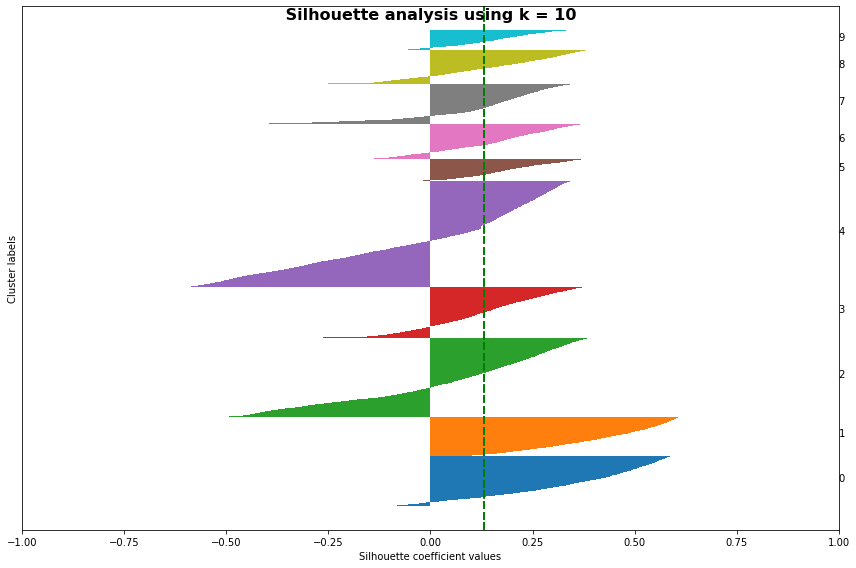

In [42]:
# silhouette plot
y_ticks = []
y_lower = y_upper = 0
fig, ax = plt.subplots(figsize=(12,8))
for i,cluster in enumerate(np.unique(y_pred)):
   cluster_silhouette_vals = silhouette_vals[y_pred ==cluster]
   cluster_silhouette_vals.sort()
   y_upper += len(cluster_silhouette_vals)
   
   ax.barh(range(y_lower,y_upper), cluster_silhouette_vals,height =1);
   ax.text(1,(y_lower+y_upper)/2,str(i))
   y_lower += len(cluster_silhouette_vals)
       
   # Get the average silhouette score 
   avg_score = np.mean(silhouette_vals)
   ax.axvline(avg_score,linestyle ='--',
   linewidth =2,color = 'green')
   ax.set_yticks([])
   ax.set_xlim([-1, 1])
   ax.set_xlabel('Silhouette coefficient values')
   ax.set_ylabel('Cluster labels')
   #ax.set_title('Silhouette plot for the various clusters');
    
   plt.tight_layout()
   plt.suptitle(f' Silhouette analysis using k = {k}',fontsize=16,fontweight = 'semibold')

In [161]:
dfDados[dfDados['y_pred']==4][['category','y_pred']].groupby('category').count().reset_index().rename(columns={'y_pred':'qtd'}).sort_values(by='qtd', ascending=False)

,category,qtd
18,esporte,368
21,folhinha,356
9,comida,343
16,empreendedorsocial,298
30,midia,267
2,bbc,248
31,miscelanea,243
24,ilustrada,225
12,cotidiano,200
27,local,167


In [162]:
dfDados[dfDados['y_pred']==4].sample(10)

,text,category,category_nro,y_pred
4340,"O lateral esquerdo Henrique, de 27 anos, pode se transferir do Vasco para o Lyon, da França. O UOL Esporte entrou em contato rápido com Juninho Pernambucano, diretor-executivo de futebol do clube francês, que admitiu o interesse no jogador. A tendência é a de que o acerto ocorra em breve.\nO Cruzmaltino foi o único time que Henrique atuou em toda a sua carreira. Formado no clube, ele ficou fora dos planos do técnico Marcelo Cabo nesta temporada e vinha treinando em horários alternativos. Seu contrato termina em 2 de agosto deste ano. A informação inicial do interesse no jogador foi dada pelo jornal francês ""L'Equipe"".\nCaso se transfira para o Lyon, o lateral reencontrará Juninho Pernambucano, que agora é diretor-executivo de futebol do clube francês. Eles atuaram juntos pelo Vasco em 2013, quando Henrique teve seu primeiro ano como profissional.\nO elenco atual do Lyon conta com quatro brasileiros: o zagueiro Marcelo e os meias Thiago Mendes, Bruno Guimarães e Lucas Paquetá, além de Cláudio Caçapa na comissão técnica.\nPelo Vasco, Henrique tem 192 partidas disputadas e um gol marcado. Em todo esse período, nunca chegou a cair nas graças da torcida.",esporte,3,4
11716,"A primeira coisa que você pega no armário quando chega o frio é o casaco, certo? Pois na tirinha do desenhista Laerte a personagem Lola tem uma ideia mais original. Veja abaixo também os quadrinhos de Adão e as aventuras de Armandinho. *",folhinha,19,4
7644,"A eficácia para conter o surto de zika no país e o aumento de casos de microcefalia não está prioritariamente em fumacês e inseticidas, mas sim no combate ao criadouro do mosquito Aedes aegypti. Essa é a opinião de Paulo Ribolla, entomologista especialista em insetos e professor da Unesp, que participou nesta quarta-feira (25) de transmissão ao vivo na "" TV Folha"". ""O inseticida acaba sendo um método de controle de último caso, pois não temos mais o que fazer"", diz o professor em entrevista aos jornalistas Cláudia Collucci e Gabriel Alves, repórter especial e de ""Ciência"" da Folha, respectivamente. Segundo Ribolla, o que acontece muitas vezes é o uso indiscriminado de inseticidas que acaba selecionando linhagens resistentes. ""O mosquito não está mudando. o problema é o fato de termos muito mosquito. Talvez por um problema de controle e, em parte, por um problema ambiental"", completa. O Aedes aegypti é urbano e está intimamente associado às cidades, conforme explica Ribolla. ""Na verdade, é a gente que está criando o mosquito, indiretamente. Ele acaba sendo um ótimo vetor, pois tem íntimo contato com o homem."" Sobre o uso dos fumacês, o especialista diz não acreditar plenamente em sua eficácia, mas reconhece a utilidade do recurso. ""Com certeza o fumacê não vai eliminar o mosquito. Lógico, ele vai diminuir a população de mosquitos adultos, que justamente transmite o vírus para a gente."" Doenças transmitidas pelo Aedes aegypti",midia,8,4
5618,"A médica Gisele Palhares Gouvêa, 34, morreu baleada na noite deste sábado (25), por volta das 19h, na Linha Vermelha, altura de Pavuna, zona norte do Rio de Janeiro. Ela teria sido vítima de uma tentativa de assalto. Estava sozinha no carro, um Land Rover, e foi atingida na cabeça. Gisele era diretora da Clínica da Família de Vila de Cava, em Nova Iguaçu, município da região metropolitana do Rio. A clínica foi inaugurada em dezembro do ano passado como unidade municipal de saúde com funcionamento 24h. A médica foi levada a um hospital de Duque de Caxias, mas morreu no centro cirúrgico. Ela estaria voltando para casa, na Barra da Tijuca, após um dia de trabalho. O crime provocou comoção entre moradores de Nova Iguaçu, que usaram as redes sociais para lamentar a morte de Gisele e elogiar a forma como ela atendia os pacientes. A médica era casada com o cirurgião plástico Renato Palhares, também conhecido na cidade. Em uma rede social, Gisele registrou na tarde deste sábado que participava da inauguração de uma unidade de